# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [ ]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [ ]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [ ]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [ ]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [ ]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.

DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


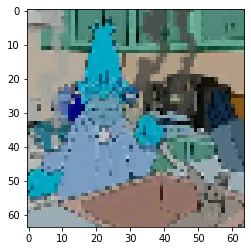

In [ ]:
plt.imshow(X[0])

In [ ]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.

perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

In [ ]:
from keras.utils import to_categorical

#Vamos a normalizar las imagenes
X = X/255.0
X_t = X_t/255.0

#Luego, la función "to_categorical" se utiliza para convertir los valores enteros de las etiquetas de las clases en un vector binario, donde cada elemento representa una clase.
y, y_t = to_categorical(y), to_categorical(y_t)

In [ ]:
from sklearn.model_selection import train_test_split

#Lo que estamos haciendo aquí es separar las imagenes en una proporción de 80% train y 20% test
X, X_val, y, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from keras.layers.normalization.batch_normalization_v1 import BatchNormalization
from keras import layers
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Crear modelo
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(64,64,3)))
BatchNormalization(),
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
BatchNormalization(),
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3,3), activation='relu'))
BatchNormalization(),
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(18, activation='softmax'))

#Conv2D: Esta capa convolucional tiene varios hiperparámetros, incluyendo el número de filtros (64, 64 y 128), el tamaño del filtro (3x3) y la función de activación (ReLU).
#BatchNormalization: Esta técnica se utiliza para normalizar las activaciones de la capa anterior, lo que ayuda a acelerar el entrenamiento de la red y mejorar su capacidad de generalización.
#MaxPooling2D: Esta capa de pooling se utiliza para reducir el tamaño de las características de salida de la capa convolucional.
#Flatten: Esta capa se utiliza para aplanar las características de salida de la capa de pooling antes de alimentarlas a la capa densa.
#Dense: Esta capa densa tiene varios hiperparámetros, incluyendo el número de neuronas (128 y 18), la función de activación (ReLU en la capa oculta y softmax en la capa de salida) y el inicializador de pesos predeterminado.
#Dropout: Esta técnica se utiliza para regularizar la red neuronal y prevenir el sobreajuste mediante la eliminación aleatoria de unidades durante el entrenamiento.

In [ ]:
from keras import optimizers

model.compile(optimizer='adam',
  loss='binary_crossentropy',
  metrics=['acc'])
history = model.fit(X, y, epochs=15, batch_size=32, validation_data=(X_val, y_val))

#Optimizador: Se utiliza el optimizador Adam.
#loss: La función de pérdida se establece en binary_crossentropy, que es una función utilizada para problemas de clasificación binaria.
#batch_size: Este hiperparámetro define el tamaño de lote utilizado en el entrenamiento y ajuste de la red neuronal.
#epochs: Este hiperparámetro define el número de veces que el modelo se ajusta a los datos de entrenamiento durante el entrenamiento.
#validation_data: Este hiperparámetro especifica los datos utilizados para la validación del modelo durante el entrenamiento, lo que ayuda a monitorear el rendimiento del modelo en datos no vistos durante el entrenamiento.

Epoch 1/15
475/475 [==============================] - 18s 11ms/step - loss: 0.2118 - acc: 0.2104 - val_loss: 0.1442 - val_acc: 0.4993
Epoch 2/15
475/475 [==============================] - 5s 9ms/step - loss: 0.1488 - acc: 0.4682 - val_loss: 0.1118 - val_acc: 0.6160
Epoch 3/15
475/475 [==============================] - 4s 9ms/step - loss: 0.1186 - acc: 0.5949 - val_loss: 0.0929 - val_acc: 0.6923
Epoch 4/15
475/475 [==============================] - 4s 9ms/step - loss: 0.0969 - acc: 0.6760 - val_loss: 0.0735 - val_acc: 0.7620
Epoch 5/15
475/475 [==============================] - 4s 9ms/step - loss: 0.0796 - acc: 0.7438 - val_loss: 0.0731 - val_acc: 0.7594
Epoch 6/15
475/475 [==============================] - 4s 9ms/step - loss: 0.0672 - acc: 0.7926 - val_loss: 0.0599 - val_acc: 0.8118
Epoch 7/15
475/475 [==============================] - 4s 8ms/step - loss: 0.0560 - acc: 0.8292 - val_loss: 0.0544 - val_acc: 0.8371
Epoch 8/15
475/475 [==============================] - 4s 9ms/step - loss: 

In [ ]:
# Evaluar el modelo en el conjunto de prueba
test_loss, test_acc = model.evaluate(X_t, y_t)
print("Test accuracy:", test_acc)

28/28 [==============================] - 0s 8ms/step - loss: 0.0158 - acc: 0.9674
Test accuracy: 0.9674157500267029


In [ ]:
from sklearn.metrics import classification_report
# Obtener predicciones en el conjunto de test

prediccion = model.predict(X_t)

# Obtener métricas de precisión y recall por clase

target_names = list(MAP_CHARACTERS.values())
informe = classification_report(np.argmax(y_t,axis=1), 
                                np.argmax(prediccion,axis=1), 
                                target_names=target_names)
print(informe)

28/28 [==============================] - 0s 3ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.96      0.96      0.96        48
  apu_nahasapeemapetilon       0.96      1.00      0.98        50
            bart_simpson       0.94      0.92      0.93        50
charles_montgomery_burns       0.92      0.96      0.94        48
            chief_wiggum       0.98      0.98      0.98        50
          comic_book_guy       1.00      0.94      0.97        49
          edna_krabappel       0.98      0.94      0.96        50
           homer_simpson       0.91      0.98      0.94        50
           kent_brockman       1.00      0.98      0.99        50
        krusty_the_clown       0.96      1.00      0.98        50
            lisa_simpson       0.96      0.92      0.94        50
           marge_simpson       1.00      1.00      1.00        50
     milhouse_van_houten       1.00      1.00      1.00        49
             moe_szysl

Como podemos observar en los resultados anteriores, el personaje con menos precisión es *charles_montgomery_burns*.

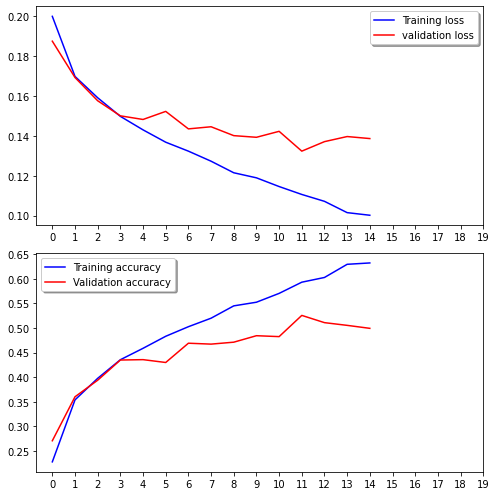

In [ ]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(20))
#ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)
ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(20))
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [ ]:
# Crear modelo fully connected
mod = Sequential()
mod.add(Flatten(input_shape=(64,64,3)))
mod.add(Dense(64, activation='relu'))
mod.add(Dense(64, activation='relu'))
mod.add(Dense(128, activation='relu'))
mod.add(Dense(256, activation='relu'))
mod.add(Dense(18, activation='softmax'))

mod.compile(optimizer='adam',
  loss='binary_crossentropy',
  metrics=['acc'])
hist = mod.fit(X, y, epochs=15, batch_size=32, validation_data=(X_val, y_val))

#input_shape: Define la forma de los datos de entrada, que son imágenes de 64x64 píxeles con 3 canales de color (RGB).
#Dense: Esta capa densa tiene varios hiperparámetros, incluyendo el número de neuronas (18, 64 y 128), la función de activación (ReLU).
#softmax: Se utiliza la función de activación softmax en la capa de salida para convertir las salidas en una distribución de probabilidades de 18 clases.
#Optimizador: Se utiliza el optimizador Adam.
#loss: La función de pérdida se establece en binary_crossentropy, que es una función utilizada para problemas de clasificación binaria.
#batch_size: Este hiperparámetro define el tamaño de lote utilizado en el entrenamiento y ajuste de la red neuronal.
#epochs: Este hiperparámetro define el número de veces que el modelo se ajusta a los datos de entrenamiento durante el entrenamiento.
#validation_data: Este hiperparámetro especifica los datos utilizados para la validación del modelo durante el entrenamiento, lo que ayuda a monitorear el rendimiento del modelo en datos no vistos durante el entrenamiento.


Epoch 1/15
475/475 [==============================] - 5s 6ms/step - loss: 0.2030 - acc: 0.2133 - val_loss: 0.1807 - val_acc: 0.2819
Epoch 2/15
475/475 [==============================] - 2s 5ms/step - loss: 0.1706 - acc: 0.3438 - val_loss: 0.1625 - val_acc: 0.3883
Epoch 3/15
475/475 [==============================] - 2s 5ms/step - loss: 0.1593 - acc: 0.3945 - val_loss: 0.1570 - val_acc: 0.4072
Epoch 4/15
475/475 [==============================] - 2s 5ms/step - loss: 0.1498 - acc: 0.4307 - val_loss: 0.1621 - val_acc: 0.3972
Epoch 5/15
475/475 [==============================] - 3s 6ms/step - loss: 0.1426 - acc: 0.4653 - val_loss: 0.1510 - val_acc: 0.4291
Epoch 6/15
475/475 [==============================] - 2s 5ms/step - loss: 0.1389 - acc: 0.4757 - val_loss: 0.1433 - val_acc: 0.4591
Epoch 7/15
475/475 [==============================] - 2s 5ms/step - loss: 0.1324 - acc: 0.5033 - val_loss: 0.1452 - val_acc: 0.4441
Epoch 8/15
475/475 [==============================] - 2s 5ms/step - loss: 0.

In [ ]:
# Obtener predicciones en el conjunto de test

prediccion = mod.predict(X_t)

# Obtener métricas de precisión y recall por clase

target_names = list(MAP_CHARACTERS.values())
informe = classification_report(np.argmax(y_t,axis=1), 
                                np.argmax(prediccion,axis=1), 
                                target_names=target_names)
print(informe)

28/28 [==============================] - 0s 2ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.36      0.56      0.44        48
  apu_nahasapeemapetilon       0.62      0.90      0.73        50
            bart_simpson       0.54      0.28      0.37        50
charles_montgomery_burns       0.62      0.60      0.61        48
            chief_wiggum       0.76      0.76      0.76        50
          comic_book_guy       0.70      0.53      0.60        49
          edna_krabappel       0.72      0.58      0.64        50
           homer_simpson       0.43      0.52      0.47        50
           kent_brockman       0.83      0.68      0.75        50
        krusty_the_clown       0.80      0.74      0.77        50
            lisa_simpson       0.70      0.46      0.55        50
           marge_simpson       0.77      0.68      0.72        50
     milhouse_van_houten       0.47      0.80      0.59        49
             moe_szysl

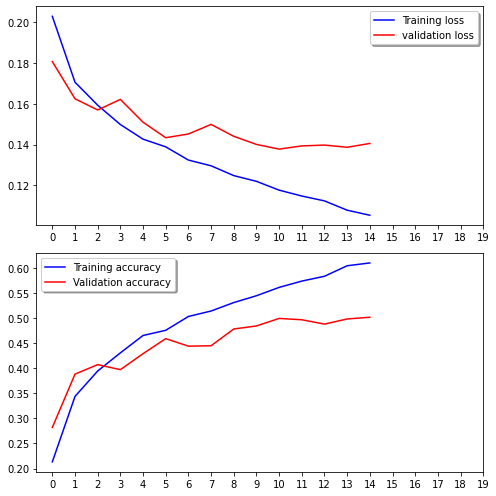

In [ ]:
import numpy as np
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))
ax1.plot(hist.history['loss'], color='b', label="Training loss")
ax1.plot(hist.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(20))
#ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend(loc='best', shadow=True)
ax2.plot(hist.history['acc'], color='b', label="Training accuracy")
ax2.plot(hist.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(20))
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

En comparación al modelo Convulcional, este modelo de Fully Connected nos da una precisión mucho menor al primer modelo.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# definir el aumento de datos
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

datagen.fit(X) #Entrenamiento

#Entrenamiento del modelo usando data augmentation
train_log = model.fit(datagen.flow(X,y,batch_size = 60),epochs = 15, validation_data=(X_val, y_val))

Epoch 1/15
254/254 [==============================] - 22s 83ms/step - loss: 0.0922 - acc: 0.7134 - val_loss: 0.0382 - val_acc: 0.8834
Epoch 2/15
254/254 [==============================] - 21s 83ms/step - loss: 0.0767 - acc: 0.7600 - val_loss: 0.0360 - val_acc: 0.8897
Epoch 3/15
254/254 [==============================] - 21s 82ms/step - loss: 0.0707 - acc: 0.7799 - val_loss: 0.0361 - val_acc: 0.8908
Epoch 4/15
254/254 [==============================] - 20s 79ms/step - loss: 0.0647 - acc: 0.7944 - val_loss: 0.0363 - val_acc: 0.8863
Epoch 5/15
254/254 [==============================] - 21s 84ms/step - loss: 0.0600 - acc: 0.8121 - val_loss: 0.0376 - val_acc: 0.8813
Epoch 6/15
254/254 [==============================] - 20s 80ms/step - loss: 0.0575 - acc: 0.8199 - val_loss: 0.0316 - val_acc: 0.9031
Epoch 7/15
254/254 [==============================] - 22s 88ms/step - loss: 0.0544 - acc: 0.8304 - val_loss: 0.0301 - val_acc: 0.9092
Epoch 8/15
254/254 [==============================] - 21s 81ms

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar. 
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados. 
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo? 
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema. 
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc. 
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.